<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/B_MSDS458_Assignment_03_EDA_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## Experiments B: RNN

Try several experiments by tweaking 

(i) architecture 

(ii) Bidirectional/unidirectional & other hyper parameters, including regularization.

## Functions and Packages

In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import string
import re

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

import nltk
from nltk.corpus import stopwords

from tensorflow.keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers.core import Dense
from keras.layers.core import Activation

### Verify TensorFlow version and Keras version

In [2]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2


In [3]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


### Stopword Function

In [4]:
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

## Mount Google Drive to Colab Environment

In [5]:
#from google.colab import drive
#drive.mount('/content/gdrive')

## Load **Data**

In [6]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

dataset,info=\
tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test'],batch_size = 32
          , as_supervised=True)

train_ds, val_ds, test_ds = dataset
text_only_train_ds = train_ds.map(lambda x, y: x)

2022-11-05 18:15:48.579268: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
W1105 18:15:48.579560 140078388901760 download_and_prepare.py:43] ***`tfds build` should be used instead of `download_and_prepare`.***
INFO[build.py]: Loading dataset ag_news_subset from imports: tensorflow_datasets.text.ag_news_subset
2022-11-05 18:15:48.690910: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "NOT_FOUND: Error executing an HTTP request: HTTP response code 404".
INFO[dataset_info.py]: Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: ag_news_subset/1.0.0
INFO[dataset_info.py]: Load dataset info from /tmp/tmpvnsys9mntfds
INFO[dataset_info.py]: Field info.spli

## Preparing Integer Sequence Datasets

In [7]:
nltk.download('stopwords')
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
max_length = 150
max_tokens = 1000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

## Experiment B1: Bi-directional RNN One-Hot Encoded Vector Sequences

1 bio-directional layer (32)

Dropout 0.5

Output activation: softmax

In [9]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.SimpleRNN(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model1 = tf.keras.Model(inputs, outputs)
model1.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 1000)        0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               66112     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 66,372
Trainable params: 66,372
Non-trainable params: 0
_________________________________________________________

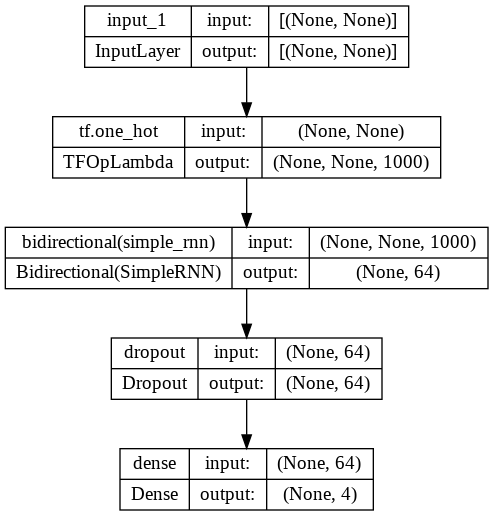

In [10]:
keras.utils.plot_model(model1, "BiDirectionalSimpleRNN.png", show_shapes=True)

In [11]:
## Train model
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history1 = model1.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model1 = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model1.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
3563/3563 [==============================] - 159s 44ms/step - loss: 0.6674 - accuracy: 0.7451 - val_loss: 0.4568 - val_accuracy: 0.8455
Epoch 2/200
3563/3563 [==============================] - 158s 44ms/step - loss: 0.4899 - accuracy: 0.8327 - val_loss: 0.4736 - val_accuracy: 0.8408
Epoch 3/200
3563/3563 [==============================] - 160s 45ms/step - loss: 0.4772 - accuracy: 0.8386 - val_loss: 0.4441 - val_accuracy: 0.8482
Epoch 4/200
3563/3563 [==============================] - 159s 45ms/step - loss: 0.4725 - accuracy: 0.8410 - val_loss: 0.4687 - val_accuracy: 0.8330
Epoch 5/200
3563/3563 [==============================] - 159s 45ms/step - loss: 0.4731 - accuracy: 0.8405 - val_loss: 0.4888 - val_accuracy: 0.8258
Epoch 6/200
238/238 [==============================] - 6s 23ms/step - loss: 0.4425 - accuracy: 0.8482
Test acc: 0.848


In [12]:
## Metrics
history_dict = history1.history
history_dict.keys()

losses = history1.history['loss']
accs = history1.history['accuracy']
val_losses = history1.history['val_loss']
val_accs = history1.history['val_accuracy']
epochs = len(losses)

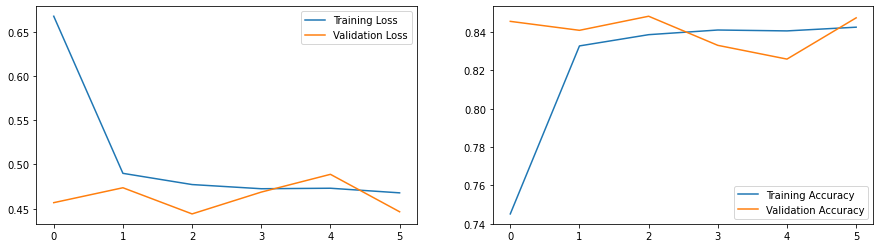

In [13]:
## Loss and Accuracy
plt.figure(figsize=(15, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Experiment B2: Bi-directional RNN One-Hot Encoded Vector Sequences

1 bio-directional layer (32)

Dropout 0.5

Output activation: Sigmoid

In [14]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.SimpleRNN(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="sigmoid")(x)
model2 = tf.keras.Model(inputs, outputs)
model2.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot_1 (TFOpLambda)   (None, None, 1000)        0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               66112     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 66,372
Trainable params: 66,372
Non-trainable params: 0
_______________________________________________________

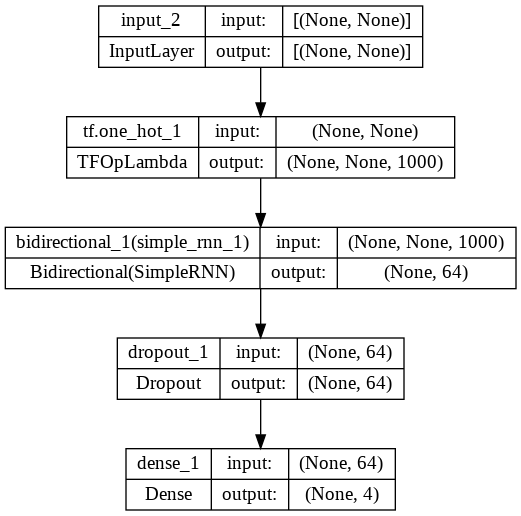

In [15]:
keras.utils.plot_model(model2, "BiDirectionalSimpleRNN2.png", show_shapes=True)

In [27]:
## Train model
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history2 = model2.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model2 = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model2.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
3563/3563 [==============================] - 125s 35ms/step - loss: 1.3875 - accuracy: 0.2518 - val_loss: 1.3867 - val_accuracy: 0.2515
Epoch 2/200
3563/3563 [==============================] - 125s 35ms/step - loss: 1.3871 - accuracy: 0.2534 - val_loss: 1.3866 - val_accuracy: 0.2515
Epoch 3/200
3563/3563 [==============================] - 124s 35ms/step - loss: 1.3869 - accuracy: 0.2484 - val_loss: 1.3866 - val_accuracy: 0.2515
Epoch 4/200
3563/3563 [==============================] - 124s 35ms/step - loss: 1.3828 - accuracy: 0.2739 - val_loss: 1.3820 - val_accuracy: 0.2747
Epoch 5/200
3563/3563 [==============================] - 124s 35ms/step - loss: 1.3805 - accuracy: 0.2786 - val_loss: 1.3776 - val_accuracy: 0.2723
Epoch 6/200
3563/3563 [==============================] - 124s 35ms/step - loss: 1.3771 - accuracy: 0.2775 - val_loss: 1.3745 - val_accuracy: 0.2843
Epoch 7/200
3563/3563 [==============================] - 124s 35ms/step - loss: 1.3776 - accuracy: 0.2817 - val_

In [28]:
## Metrics
history_dict = history2.history
history_dict.keys()

losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

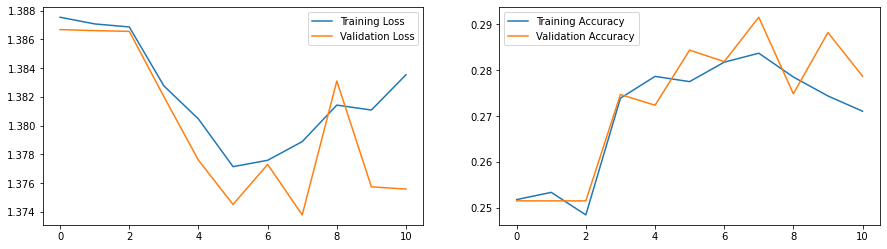

In [29]:
## Loss and Accuracy
plt.figure(figsize=(15, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Experiment B3: Unidirectional RNN One-Hot Encoded Vector Sequences

1 bio-directional layer (32)

Dropout 0.5

Output activation: Softmax

In [20]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.SimpleRNN(32)(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model3 = tf.keras.Model(inputs, outputs)
model3.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot_3 (TFOpLambda)   (None, None, 1000)        0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                33056     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 33,188
Trainable params: 33,188
Non-trainable params: 0
_________________________________________________________________


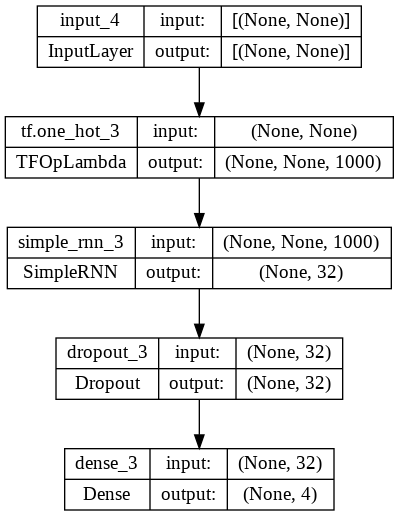

In [21]:
keras.utils.plot_model(model3, "UnidirectionalSimpleRNN3.png", show_shapes=True)

In [23]:
## Train model
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history3 = model3.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model3 = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model1.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
3563/3563 [==============================] - 125s 35ms/step - loss: 1.3877 - accuracy: 0.2585 - val_loss: 1.3774 - val_accuracy: 0.2910
Epoch 2/200
3563/3563 [==============================] - 124s 35ms/step - loss: 1.3764 - accuracy: 0.2906 - val_loss: 1.3730 - val_accuracy: 0.2937
Epoch 3/200
3563/3563 [==============================] - 124s 35ms/step - loss: 1.3733 - accuracy: 0.2913 - val_loss: 1.3814 - val_accuracy: 0.2798
Epoch 4/200
3563/3563 [==============================] - 124s 35ms/step - loss: 1.3712 - accuracy: 0.2899 - val_loss: 1.3713 - val_accuracy: 0.2940
Epoch 5/200
3563/3563 [==============================] - 125s 35ms/step - loss: 1.3756 - accuracy: 0.2851 - val_loss: 1.3885 - val_accuracy: 0.2478
Epoch 6/200
3563/3563 [==============================] - 125s 35ms/step - loss: 1.3745 - accuracy: 0.2884 - val_loss: 1.3743 - val_accuracy: 0.2943
Epoch 7/200
3563/3563 [==============================] - 124s 35ms/step - loss: 1.3744 - accuracy: 0.2909 - val_

In [24]:
## Metrics
history_dict = history3.history
history_dict.keys()

losses = history3.history['loss']
accs = history3.history['accuracy']
val_losses = history3.history['val_loss']
val_accs = history3.history['val_accuracy']
epochs = len(losses)

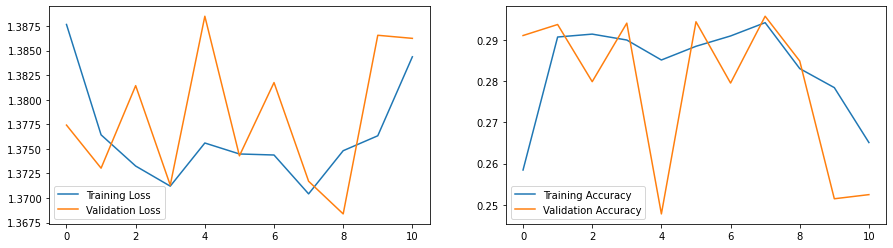

In [25]:
## Loss and Accuracy
plt.figure(figsize=(15, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Experiment B4: Bi-directional RNN One-Hot Encoded Vector Sequences

1 bio-directional layers (64)

Dropout 0.5

Output activation: softmax

In [37]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.SimpleRNN(64))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model4 = tf.keras.Model(inputs, outputs)
model4.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model4.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, None)]            0         
                                                                 
 tf.one_hot_10 (TFOpLambda)  (None, None, 1000)        0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 128)              136320    
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 516       
                                                                 
Total params: 136,836
Trainable params: 136,836
Non-trainable params: 0
_____________________________________________________

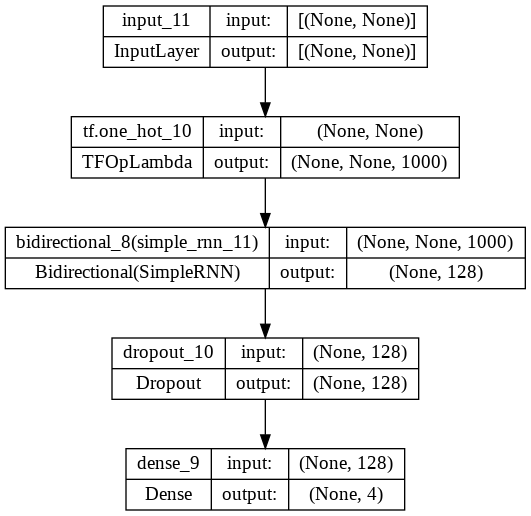

In [38]:
keras.utils.plot_model(model4, "BiDirectionalSimpleRNN2.png", show_shapes=True)

In [39]:
## Train model
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history4 = model4.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model4 = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model4.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/200
3563/3563 [==============================] - 257s 72ms/step - loss: 0.6373 - accuracy: 0.7569 - val_loss: 0.4474 - val_accuracy: 0.8458
Epoch 2/200
3563/3563 [==============================] - 256s 72ms/step - loss: 0.4750 - accuracy: 0.8350 - val_loss: 0.4599 - val_accuracy: 0.8450
Epoch 3/200
3563/3563 [==============================] - 256s 72ms/step - loss: 0.4564 - accuracy: 0.8421 - val_loss: 0.4891 - val_accuracy: 0.8317
Epoch 4/200
3563/3563 [==============================] - 255s 72ms/step - loss: 0.4376 - accuracy: 0.8501 - val_loss: 0.4450 - val_accuracy: 0.8502
Epoch 5/200
3563/3563 [==============================] - 255s 71ms/step - loss: 0.4271 - accuracy: 0.8544 - val_loss: 0.4394 - val_accuracy: 0.8482
Epoch 6/200
3563/3563 [==============================] - 254s 71ms/step - loss: 0.4211 - accuracy: 0.8569 - val_loss: 0.4487 - val_accuracy: 0.8455
Epoch 7/200
238/238 [==============================] - 6s 25ms/step - loss: 0.4309 - accuracy: 0.8521
Test acc: 

In [42]:
## Metrics
history_dict = history2.history
history_dict.keys()

losses = history4.history['loss']
accs = history4.history['accuracy']
val_losses = history4.history['val_loss']
val_accs = history4.history['val_accuracy']
epochs = len(losses)

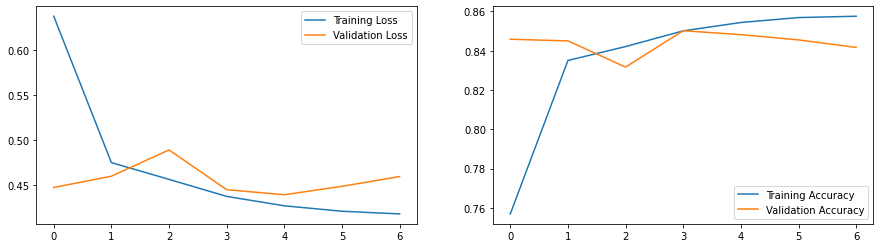

In [43]:
## Loss and Accuracy
plt.figure(figsize=(15, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Model Leveraging Trained Embedding Layer

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.SimpleRNN(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

In [ ]:
## Train model
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

In [ ]:
keras.utils.plot_model(model2, "BiDirectionalSimpleRNN2.png", show_shapes=True)

In [ ]:
## Metrics
history_dict = history2.history
history_dict.keys()

losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

In [ ]:
## Loss and Accuracy
plt.figure(figsize=(15, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Model Leveraging Embedding Layer With Masking Enabled

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

## Using Pretrained Word Embeddings

The rationale behind using `pretrained word embedding`s in natural language processing is much the same as for using pretrained convnets in image classification: *you don’t have enough data available to learn truly powerful features on your own*, but you expect that the features you need are fairly generic—that is, common visual features or semantic features. In this case, it makes sense to reuse features learned on a different problem.

The idea of a dense, low-dimensional embedding space for words, computed in an unsupervised way, was initially explored by Bengio et al. in the early 2000s, but it only started to take off in research and industry applications after the release of one of the most famous and successful word-embedding schemes: the `Word2Vec` algorithm (https://code.google.com/archive/p/word2vec), developed by Tomas Mikolov at Google in 2013. `Word2Vec` dimensions capture specific semantic properties, such as gender.

There are various precomputed databases of word embeddings that you can download and use in a Keras Embedding layer. `Word2vec` is one of them. Another popular one is called `Global Vectors for Word Representatio`n (GloVe, https://nlp.stanford.edu/projects/glove), which was developed by Stanford researchers in 2014. This embedding technique is based on factorizing a matrix of word co-occurrence statistics. Its developers have made available precomputed embeddings for millions of English tokens, obtained from Wikipedia data and Common Crawl data.

First, let’s download the GloVe word embeddings precomputed on the 2014 English Wikipedia dataset. It’s an 822 MB zip file containing 100-dimensional embedding vectors for 400,000 words (or non-word tokens).

<div class="alert alert-block alert-success"><b>GloVe: Global Vectors for Word Representation</b><br>
https://nlp.stanford.edu/projects/glove/</div>

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

## Parsing The GloVe Word-Embeddings File

First line of `glove.6B.100d.txt`:

`the -0.038194 -0.24487 0.72812 ...`

In [ ]:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ") # np.dtype('f') returns dtype('float32')
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

## Preparing The GloVe Word-Embeddings Matrix

Next, let’s build an embedding matrix that you can load into an Embedding layer. It must be a matrix of shape `(max_words, embedding_dim)`, where each entry *i* contains the `embedding_dim`-dimensional vector for the word of index *i* in the reference word index (built during tokenization).

In [ ]:
embedding_dim = 100

# Retrieve the vocabulary indexed by our previous TextVectorization layer.
vocabulary = text_vectorization.get_vocabulary()

# Use it to create a mapping from words to their index in the vocabulary.
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Prepare a matrix that we’ll fill with the GloVe vectors.
embedding_matrix = np.zeros((max_tokens, embedding_dim))

# Fill entry i in the matrix with the word vector for index i.
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:  # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

We’re now ready to train a new model—identical to our previous model, but leveraging the `100-dimensional` pretrained GloVe embeddings instead of `256-dimensional` learned embeddings.

## One possible alternative to GloVE: ELMo (Embedding from Language Models)

## Model Leveraging Pretrained (GloVe) Embedding Layer

In [ ]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")